# General Index Labeling Test
Small scale testing of general index data & processing

---
Created 6/3/22 by Ian Hay   
Updated 6/20/22

In [ ]:
# to do
#
# DONE - word2vec model
# DONE - build & plot co-ocurrence matrix
# DONE - build cosine similarity adjacency matrix/list
# - token lemmatization & stemming (if necessary, maybe not given the context of ngrams)
# DONE - validate vector processing and networks
# - topic extraction models
# - dimensional reduction models for similarity calculation
# - hyperparameter tuning

### Imports
Dependencies

---
[Python 3.8+](https://www.python.org/downloads/release/python-380/)    
[Pandas](https://pandas.pydata.org/)   
[NumPy](https://numpy.org/)    
[NetworkX](https://networkx.org/)  
[pyvis](https://pyvis.readthedocs.io/en/latest/install.html)   
[scikit-learn](https://scikit-learn.org/stable/index.html)

In [1]:
from time import time
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import nltk
nltk.download('stopwords')
import gensim
import spacy
nlp = spacy.load("en_core_web_sm")
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from pyvis import network as net
from pyvis.network import Network
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ianha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Functions

In [21]:
# Data Processing -------------------------------------------------------------------------------------------

def getDocColumn(df, column, newColumnName):
    """
    Given a dataframe and a column of datatype list, constructs
    a new column newColumnName with the list joined into a single
    string and items separated by spaces (" ").
    """
    strDict = {}
    for row in range(len(df)):
        text = " ".join(df.iloc[row][column])
        strDict[df.index[row]] = text
    dfStr = pd.Series(strDict, name=newColumnName)
    df[newColumnName] = dfStr

def getBackOfWordsDF(df, docColumn):
    """
    """
    countvec = CountVectorizer()
    X = countvec.fit_transform(df[docColumn])
    dfBOW = pd.DataFrame(X.toarray(),columns=countvec.get_feature_names_out())
    dfBOW.set_index(df.index, inplace=True)
    return dfBOW

def getNounsAndVerbs(df, column, newColumnName):
    """
    Utilizes Spacy to extract nouns and verbs from ngrams
    and build a new column with only these terms.
    """
    nounAndVerbDict = {}
    for row in range(len(df)):
        text = " ".join(df.iloc[row][column])
        doc = nlp(text)
        nounList = [chunk.text for chunk in doc.noun_chunks]
        verbList = [token.lemma_ for token in doc if token.pos_ == "VERB"]
        nounAndVerbDict[df.index[row]] = nounList + verbList
    dfNounAndVerb = pd.Series(nounAndVerbDict, name=newColumnName)
    df[newColumnName] = dfNounAndVerb

def removeStopWords(df, column):
    """
    Takes in a dataframe and a doc column (words in a single string separated by spaces).
    https://stackoverflow.com/questions/29523254/python-remove-stop-words-from-pandas-dataframe
    """
    from nltk.corpus import stopwords
    _stopWords = list(stopwords.words('english'))
    df[column] = df[column].apply(lambda x: ' '.join([word for word in x.split() if word not in (_stopWords)]))

def getUniqueWordsColumn(df, column, newColumnName, nonWords=[]):
    """
    Given a dataframe and column, constructs a new column with name newColumnName
    of the unique words in  df[column].
    The object in  df[column]  must be a list of strings.
    Returns the updated dataframe.
    """

    ### deprecated ###

    df[newColumnName] = df[column]
    for row in range(len(df[newColumnName])):
        df[newColumnName][row] = df[column].iloc[row]
        string_list = []
        for string in df[newColumnName].iloc[row]:
            string_list.append(string.split(" ")) # splits words into list of individual word strings
        string_list = list(itertools.chain(*string_list)) # concatenates nested list into 1D list
        string_list = list(set(string_list)) # grabs only unique string items
        for nonword in nonWords:
            if nonword in string_list:
                string_list.remove(nonword)
        df.loc[newColumnName].iloc[row] = string_list # bad
    return df

def buildAdjacencyMatrixByColumn(df, column):
    """
    Given a dataframe and a column, constructs an adjacency matrix
    of size [n x n] where  n  is the number of rows of the dataframe.
    The adjacency matrix edge weights represent the number of similar elements.
    The datatype in  df[column]  must be a list.
    """
    n = len(df[column])
    adjMatrix = np.zeros((n, n))
    for n1 in range(n):
        ngram1 = df[column].iloc[n1]
        for n2 in range(n):
            ngram2 = df[column].iloc[n2]
            numSimilar = numSimilarStrings(ngram1, ngram2)
            if n1 != n2 & numSimilar > 0: # removes recursive edges
                adjMatrix[n1][n2] = numSimilar 
    return adjMatrix

def buildAdjacencyListByColumn(df, column):
    """
    Given a dataframe and a column, constructs an adjacency list
    as a nestd dictionary with  n  keys in the outermost dict, where
    n  is the number of rows in the dataframe.
    The adjacency list edge weights represent the number of similar elements.
    The datatype in  df[column]  must be a list.
    """
    n = len(df[column])

    adjDict = {} # consider using the hash to represent nodes instead of numbers
    for n1 in range(n):

        nodeDict = {}
        ngram1 = df[column].iloc[n1]
        for n2 in range(n):
            ngram2 = df[column].iloc[n2]
            numSimilar = numSimilarStrings(ngram1, ngram2)
            if n1 != n2 & numSimilar > 0: # removes recursive edges
                nodeDict[n2] = {"weight" : numSimilar} # https://networkx.org/documentation/stable/reference/generated/networkx.convert.from_dict_of_dicts.html
        adjDict[n1] = nodeDict

    return adjDict

def buildAdjacencyMatrixByCoOccurence(dfBOW):
    """
    """
    X = np.array(dfBOW.values)
    coocc = np.dot(X.T, X)
    np.fill_diagonal(coocc, 0)
    return coocc

def buildVectorMatrixByColumn(df, docColumn):
    """
    Given a dataframe and a column storing documents,
    trains a gensim doc2vec model and outputs
    the vector matrix.
    """
    def read_corpus(documents):
        for i, plot in enumerate(documents):
            yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(plot, max_len=30), [i])

    train_corpus = list(read_corpus(df[docColumn]))
    model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=55)
    model.build_vocab(train_corpus)
    model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)
    docVectors = model.dv.vectors
    return docVectors

def buildAdjacencyMatrixByCosineSimilarity(vecMatrix):
    """
    Given a vector matrix, computes the cosine similarity score
    between rows of the matrix and stores the values in an
    adjacency matrix.
    """
    n = len(vecMatrix)
    cosSimMatrix = np.zeros((n,n))
    for row in range(n):
        a = vecMatrix[row]
        for otherRow in range(n):
            b = vecMatrix[otherRow]
            cosSimMatrix[row][otherRow] = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
    np.fill_diagonal(cosSimMatrix, 0)
    return cosSimMatrix

In [22]:
# Utility --------------------------------------------------------------------------------------------------

def loadTextFileIntoDataframe(filepath, columns, splittingChar="\t"):
    """
    Opens the given filepath into a pandas dataframe.
    Splits the list by the denoted character, by default tab.
    Returns a pandas dataframe.
    """
    with open(filepath) as file:
        data = file.readlines()
    df = pd.DataFrame(columns=columns)
    for line in data:
        lineSplit = [line.split(splittingChar)]
        if len(lineSplit[0]) < len(columns):
            for x in range(len(columns) - len(lineSplit[0])):
                lineSplit[0].append("0")
        lineDF = pd.DataFrame(lineSplit, columns=columns)
        df = pd.concat([df, lineDF], axis=0, ignore_index=True)
    return df

def numSimilarStrings(stringList1, stringList2):
    """
    Given two lists of strings, returns the number of strings they both share.
    In other words, the size of the subset intersection of stringList1 and stringList2.
    """

    # is there a faster way to do this with sets?

    count = 0
    for string in stringList1:
        if string in stringList2:
            count = count + 1
    return count

def subtractListsOfInts(_list1, _list2):
    """
    Given two lists of items, returns a list of items
    in _list1 and not in _list2.
    Utilizes collections.Counter
    Returns a list of items.

    https://stackoverflow.com/questions/2070643/subtracting-two-lists-in-python
    """
    _set1 = Counter(_list1)
    _set2 = Counter(_list2)
    _set1_2 = _set1 - _set2
    return list(_set1_2.elements())

def cosineSimilarityNumMostSimilar(model, word, target_list, num):
    """
    https://towardsdatascience.com/a-beginners-guide-to-word-embedding-with-gensim-word2vec-model-5970fa56cc92
    """
    cosine_dict ={}
    word_list = []
    a = model[word]
    for item in target_list :
        if item != word :
            b = model [item]
            cos_sim = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
            cosine_dict[item] = cos_sim
    dist_sort=sorted(cosine_dict.items(), key=lambda dist: dist[1],reverse = True) ## in descending order 
    for item in dist_sort:
        word_list.append((item[0],  item[1]))
    return word_list[0:num]

def standardizeDataColumn(df, column, newColumnName):
    """
    Standardizes the column of the dataframe df.
    Adds the new column newColumnName to the dataframe inplace.
    Utilizes SKLearn.preprocessing.standardscaler.
    Mean is 0, variance is 1
    """
    scaler = StandardScaler()
    scaledSeries = pd.Series(np.reshape(scaler.fit_transform(np.array(df[column]).reshape(-1, 1)), (-1)), name=newColumnName, index=df.index)
    scaledSeries = scaledSeries + 1 # adding 1 scales most (~98%) to be in range [0, 2] for graphing purposes
    df[newColumnName] = scaledSeries


In [23]:
# Visualization -------------------------------------------------------------------------------------------

def visualizeNetworkHTML(_graph, _filename, _width="1920px", _height="1080px", _physics=False):
    """
    Given a NetworkX graph and the filename to save to, builds an HTML
    graph of that network. Optional parameters are width and height of graph.
    Uses pyvis to build an interactive HTML graph of a NetworkX graph.
    Uses NetworkX for graph storage.
    """
    _net = Network(width=_width, height=_height, notebook=True)
    _net.toggle_physics(_physics)
    _net.barnes_hut()
    _net.from_nx(_graph)
    _net.show(_filename)

def plot_top_words_one_topic(model, feature_names, n_top_words, title):
    """
    https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py
    """
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        plt.barh(top_features, weights, height=0.7)
        plt.tick_params(axis="both", which="major", labelsize=12)
        plt.suptitle(title, fontsize=25)
    plt.show()

def plot_top_words(model, feature_names, n_top_words, title, n_topics):
    """
    https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py
    """
    fig, axes = plt.subplots(1, n_topics, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 20})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=25)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

def drawNetworkgraph(networkx_graph,notebook=True,output_filename='graph.html',show_buttons=True,only_physics_buttons=False,
                height=None,width=None,bgcolor=None,font_color=None,pyvis_options=None):
    """
    https://gist.github.com/maciejkos/e3bc958aac9e7a245dddff8d86058e17
    
    This function accepts a networkx graph object,
    converts it to a pyvis network object preserving its node and edge attributes,
    and both returns and saves a dynamic network visualization.
    Valid node attributes include:
        "size", "value", "title", "x", "y", "label", "color".
        (For more info: https://pyvis.readthedocs.io/en/latest/documentation.html#pyvis.network.Network.add_node)
    Valid edge attributes include:
        "arrowStrikethrough", "hidden", "physics", "title", "value", "width"
        (For more info: https://pyvis.readthedocs.io/en/latest/documentation.html#pyvis.network.Network.add_edge)
    Args:
        networkx_graph: The graph to convert and display
        notebook: Display in Jupyter?
        output_filename: Where to save the converted network
        show_buttons: Show buttons in saved version of network?
        only_physics_buttons: Show only buttons controlling physics of network?
        height: height in px or %, e.g, "750px" or "100%
        width: width in px or %, e.g, "750px" or "100%
        bgcolor: background color, e.g., "black" or "#222222"
        font_color: font color,  e.g., "black" or "#222222"
        pyvis_options: provide pyvis-specific options (https://pyvis.readthedocs.io/en/latest/documentation.html#pyvis.options.Options.set)
    """

    # make a pyvis network
    network_class_parameters = {"notebook": notebook, "height": height, "width": width, "bgcolor": bgcolor, "font_color": font_color}
    pyvis_graph = net.Network(**{parameter_name: parameter_value for parameter_name, parameter_value in network_class_parameters.items() if parameter_value})

    # for each node and its attributes in the networkx graph
    for node,node_attrs in networkx_graph.nodes(data=True):
        pyvis_graph.add_node(node,**node_attrs)

    # for each edge and its attributes in the networkx graph
    for source,target,edge_attrs in networkx_graph.edges(data=True):
        # if value/width not specified directly, and weight is specified, set 'value' to 'weight'
        if not 'value' in edge_attrs and not 'width' in edge_attrs and 'weight' in edge_attrs:
            # place at key 'value' the weight of the edge
            edge_attrs['value']=edge_attrs['weight']
        # add the edge
        pyvis_graph.add_edge(source,target,**edge_attrs)

    # turn buttons on
    if show_buttons:
        if only_physics_buttons:
            pyvis_graph.show_buttons(filter_=['physics'])
        else:
            pyvis_graph.show_buttons()

    # pyvis-specific options
    if pyvis_options:
        pyvis_graph.set_options(pyvis_options)

    # return and also save
    return pyvis_graph.show(output_filename)

def display_closestwords_tsnescatterplot(model, word, size):
    """
    https://towardsdatascience.com/a-beginners-guide-to-word-embedding-with-gensim-word2vec-model-5970fa56cc92
    """
    arr = np.empty((0,size), dtype='f')
    word_labels = [word]
    close_words = model.similar_by_word(word)
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
            
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.scatter(x_coords, y_coords)
    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
        plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
        plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
        plt.show()


### Building Dataframe

In [5]:
# hard coded things
columnListNGrams = ["hash", "ngram", "ngram_lc", "ngram_tokens", "ngram_count", "term_freq", "doc_count", "date_added"]
columnListKeywords = ["hash", "keywords", "keywords_lc", "keyword_tokens", "keyword_score", "doc_count", "insert_date"]

non_words = ["a", "at", "an", "am", "and", "that", "like", "for", "by", "i", "in", "of", "or", "be", "use", "as", "on", "the", "to", "with", "-pron-"]

filenameAnteNGrams = "data/doc_ngrams/sample.fgrep.antediluvian.txt"
filepathHennigNGrams = "data/doc_ngrams/sample.fgrep.Hennig86.txt"
filenameAnteKeywords = "data/doc_keywords/sample.fgrep.antedivulian.txt"

In [6]:
# load test files into dataframe

indexCol = columnListNGrams[0]
df_antedivulian = loadTextFileIntoDataframe(filepath=filenameAnteNGrams, columns=columnListNGrams)
df_hennig = loadTextFileIntoDataframe(filepath=filepathHennigNGrams, columns=columnListNGrams)
df = pd.concat([df_antedivulian, df_hennig])
df = df.groupby(indexCol).agg(list)

In [7]:
# process data columns

yakeScoreCol = columnListNGrams[5]
for n in range(len(df)):
    term_freq_list = df[yakeScoreCol].iloc[n]
    df[yakeScoreCol][n] = term_freq_list[0]
df[yakeScoreCol] = df[yakeScoreCol].astype(float)

standardizeDataColumn(df, yakeScoreCol, "normalized_term_freq")
getNounsAndVerbs(df, "ngram_lc", "ngram_lc_nounsverbs")
getDocColumn(df, "ngram_lc_nounsverbs", "ngram_lc_nounverbs_doc")
removeStopWords(df, "ngram_lc_nounverbs_doc")
df.head()

,ngram,ngram_lc,ngram_tokens,ngram_count,term_freq,doc_count,date_added,normalized_term_freq,ngram_lc_nounsverbs,ngram_lc_nounverbs_doc
hash,,,,,,,,,,
3002e8a37ec9d00a67bdf0004b8628c35d72068d,"[antediluvian, antediluvian humanity]","[antediluvian, antediluvian humanity]","[1, 2]","[1, 1]",0.000010,"[1, 1]","[\N\n, \N\n]",0.345035,[antediluvian antediluvian humanity],antediluvian antediluvian humanity
3005b3bf055ddcb3c25e4742a72ee16728934efd,"[antediluvian, antediluvian refrain, follow by...","[antediluvian, antediluvian refrain, follow by...","[1, 2, 4, 5]","[1, 1, 1, 1]",0.000281,"[1, 1, 1, 1]","[\N\n, \N\n, \N\n, \N\n]",0.995948,"[antediluvian antediluvian refrain follow, an ...",antediluvian antediluvian refrain follow anted...
3005ebfe5508340797dbfcce8454f3d3f6f76eb1,"[antediluvian, antediluvian dream, cave of -PR...","[antediluvian, antediluvian dream, cave of -pr...","[1, 2, 4, 5, 5]","[1, 1, 1, 1, 1]",0.000091,"[1, 1, 1, 1, 1]","[2021-09-03\n, 2021-09-03\n, 2021-09-03\n, 202...",0.540615,"[antediluvian antediluvian dream cave, -pron- ...",antediluvian antediluvian dream cave -pron- an...
30064ae161de1e9a96992be108c195796f13e72a,"[Hennig86 program, routine in the Hennig86, ro...","[hennig86 program, routine in the hennig86, ro...","[2, 4, 5, 1]","[1, 1, 1, 1]",0.000198,"[1, 1, 1, 1]","[\N\n, \N\n, \N\n, \N\n]",0.797378,"[hennig86 program routine, the hennig86 routin...",hennig86 program routine hennig86 routine henn...
30136ab3788ab8e8be6b939901ec669a41ef896a,[antediluvian],[antediluvian],[1],[1],0.000051,[1],[\N\n],0.443641,[],


##### Doc2Vec Model

In [32]:
docVectors = buildVectorMatrixByColumn(df, "ngram_lc_nounverbs_doc")
docVecDF = pd.DataFrame(docVectors)
docVecDF.describe()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,...,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,-0.072705,-0.012144,0.043051,0.158017,-0.100112,-0.155348,0.164185,0.051445,-0.182653,-0.088846,...,0.153433,0.093441,-0.143128,-0.042140,0.229253,0.140721,0.076926,0.005713,0.144294,0.128573
std,0.108469,0.097756,0.128978,0.176946,0.137010,0.146293,0.201721,0.137234,0.171574,0.124416,...,0.205259,0.137939,0.191497,0.130889,0.257813,0.178965,0.191840,0.169642,0.153278,0.194792
min,-0.853676,-1.067075,-0.696041,-0.402517,-1.383216,-1.325225,-0.242006,-1.041748,-1.699070,-1.059358,...,-0.502535,-1.125734,-2.546732,-1.280309,-1.002461,-0.413981,-1.221285,-1.856502,-0.297146,-0.783476
25%,-0.109987,-0.040967,0.002276,0.053969,-0.140002,-0.213288,0.048265,-0.002618,-0.240760,-0.126933,...,0.037346,0.025178,-0.192142,-0.082109,0.087291,0.046375,0.005871,-0.033729,0.047823,0.034381
50%,-0.068171,-0.010951,0.035658,0.151151,-0.097372,-0.145907,0.154161,0.046175,-0.173775,-0.082560,...,0.146775,0.085368,-0.135413,-0.038836,0.224688,0.131942,0.060591,0.003366,0.133989,0.112202
75%,-0.014290,0.011070,0.070147,0.209093,-0.020863,-0.055427,0.219080,0.090751,-0.080380,-0.026964,...,0.206739,0.126393,-0.026023,0.006852,0.320670,0.192954,0.114209,0.038656,0.200829,0.178485
max,0.415656,0.660765,2.020453,1.950132,0.640052,0.296327,2.959599,1.697171,0.317200,0.459646,...,2.661077,1.344022,0.618735,0.507751,2.804783,2.299926,2.915113,1.831067,1.677571,2.983070


In [9]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

db = DBSCAN(eps=0.3, min_samples=10).fit(docVectors)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(labels) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(docVectors, labels))

Estimated number of clusters: 767
Estimated number of noise points: 388
Silhouette Coefficient: 0.100


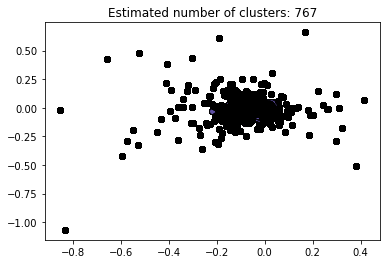

In [10]:
# Black removed and is used for noise instead.
unique_labels = labels
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = docVectors[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = docVectors[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

##### Word2Vec Model

In [54]:
train_corpus = list(df["ngram_lc_nounsverbs"])
model = gensim.models.word2vec.Word2Vec(train_corpus, min_count=1,vector_size= 10,workers=3, window =3, sg = 1)
model.build_vocab(train_corpus)
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)
wordVectors = model.wv.vectors
pd.DataFrame(wordVectors)

,0,1,2,3,4,5,6,7,8,9
0,-0.093458,0.038209,0.060096,-0.068038,0.016778,-0.017029,0.006674,-0.089345,0.015909,-0.056390
1,0.063466,-0.074041,-0.036476,-0.061916,0.069947,-0.015884,-0.087015,0.075765,0.083060,-0.038954
2,0.105018,-0.078192,0.008479,-0.028711,-0.067771,-0.016688,-0.051185,0.100014,-0.072869,0.021513
3,0.002337,0.083924,0.027941,0.086405,0.031751,0.060147,0.052864,-0.078386,-0.060445,0.008626
4,0.031026,-0.043076,0.017594,-0.078893,0.029047,0.051193,0.055709,-0.031245,-0.090847,-0.103209
...,...,...,...,...,...,...,...,...,...,...
2265,0.008134,0.012796,-0.088510,0.088115,0.057204,0.065826,0.046668,-0.063959,-0.032735,-0.079639
2266,0.034616,0.075608,0.060039,0.085737,0.064685,0.011588,0.065582,-0.026177,-0.088932,0.049495
2267,0.047766,0.047893,-0.084575,0.075967,0.038682,0.092319,0.061845,0.039892,-0.003735,0.003073
2268,0.014850,-0.022889,-0.098817,0.035583,-0.055613,-0.005765,0.038759,-0.075075,-0.001905,0.089026


<AxesSubplot:>

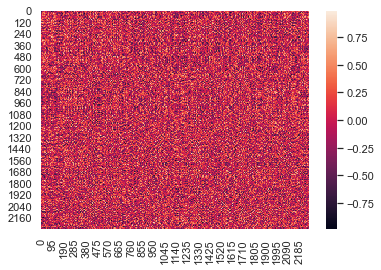

In [55]:
cosSimMatrixWords = buildAdjacencyMatrixByCosineSimilarity(wordVectors)
sns.heatmap(cosSimMatrixWords)

In [57]:
db = DBSCAN(eps=0.3, min_samples=10).fit(wordVectors)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(labels) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 2270
Estimated number of noise points: 0


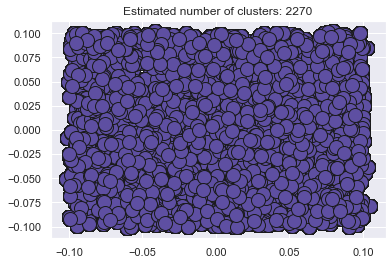

In [59]:
# Black removed and is used for noise instead.
unique_labels = labels
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = wordVectors[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = wordVectors[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

### Performance Testing

In [ ]:
#   DONE  - test adj list vs adj matrix storage
#   DONE  - test adj list vs adj matrix compute performance
#   DONE  - test building each with ngrams vs keywords
#
#  to do
# 
# - test performance and storage of scipy sparse matrix
# - test partitioning with adjList vs adjMatrix
# - test topic extraction with adjList vs adjMatrix
# - test visualizing with adjList vs adjMatrix
#
# (figure out how to validate patitioning and topic extraction)
# - test different community partition algos
# - test different topic extraction algos

In [ ]:
"""from timeit import Timer
funcList = ["buildAdjacencyMatrixByColumn", "buildAdjacencyListByColumn"]
parameterList = ["ngram_lc"]
numTests = 100

testingDict = {}
for func in funcList:
    thisTest = {}
    for param in parameterList:
        funcString = func + "(df, \"" + param + "\")"
        importString = "from __main__ import " + func + " , df"
        t = Timer(funcString, importString)
        testTime = t.timeit(number=numTests)
        thisTest["compute time (seconds)"] = testTime / numTests
    testingDict[func] = thisTest

testingDict["buildAdjacencyMatrixByColumn"]["storage (bytes)"] = sys.getsizeof(buildAdjacencyMatrixByColumn(df, parameterList[0]))
testingDict["buildAdjacencyListByColumn"]["storage (bytes)"] = sys.getsizeof(buildAdjacencyListByColumn(df, parameterList[0]))

testDF = pd.DataFrame(testingDict)
testDF.to_csv("performance testing 100 iterations.csv")
# storage in memory in bytes
# compute time in seconds
testDF
"""

In [ ]:
# the above code generated this data
pd.read_csv("performance testing 100 iterations simple numSimilar.csv", index_col="Unnamed: 0")

### Building Networks and Partitioning Communities

In [60]:
# initial community partition on all data

# column to build adajency matrix 
adjColumnName = "ngram_lc_nounsverbs"
adjColumnNameDoc = "ngram_lc_nounverbs_doc"

print("Building numSimilar() Adjacency Matrix...")
t0 = time()
adjMatrixNumSimilar = buildAdjacencyMatrixByColumn(df, adjColumnName) # number similar strings
# cosine similarity
# euclidean distance
print("Done in %0.3fs.\n" % (time() - t0))

print("Building word co-occurence Adjacency Matrix...")
t0 = time()
dfBOW = getBackOfWordsDF(df, adjColumnNameDoc)
coocAdjMatrix = buildAdjacencyMatrixByCoOccurence(dfBOW)
print("Done in %0.3fs.\n" % (time() - t0))

print("Building Doc2Vec cosine similarity Adjacency Matrix...")
t0 = time()
T = 0.95 # hyperparameter
cosSimMatrix = buildAdjacencyMatrixByCosineSimilarity(docVectors)
cosSimMatrix[cosSimMatrix < T] = 0
cosSimMatrix[cosSimMatrix >= T] = 1
print("Done in %0.3fs.\n" % (time() - t0))

print("Building Networkx Graphs...")
t0 = time()
Gsim = nx.from_numpy_array(adjMatrixNumSimilar)
Gcossim = nx.from_numpy_array(cosSimMatrix)
Gcooc = nx.from_numpy_array(coocAdjMatrix)
print("Done in %0.3fs.\n" % (time() - t0))

community_generator = nx.algorithms.community

print("Building Louvain Partitions...")
t0 = time()
communitySetsNumSimilar = community_generator.louvain_communities(Gsim, resolution=0.1)
communitySetsCossineSim = community_generator.louvain_communities(Gcossim, resolution=0.1)
communitySetsCooc = community_generator.louvain_communities(Gcooc, resolution=0.1)
print("Done in %0.3fs.\n" % (time() - t0))

print("Adding Node Metadata...")
t0 = time()
graphList = [(adjMatrixNumSimilar, Gsim, communitySetsNumSimilar, "numSimilar()"), (coocAdjMatrix, Gcooc, communitySetsCooc, "co-occurence"), (cosSimMatrix, Gcossim, communitySetsCossineSim, "vector cosine similarity")]
for graphs in graphList:
    print("Beginning " + graphs[3] + "...\n")
    numCommunities = 0
    numNodes = len(df)
    nodes = list(range(numNodes))
    scalingFactor = 5. # scales the node size for visibility
    communitySets = graphs[2]
    G = graphs[1]
    adjMatrix = graphs[0]

    node_to_community = {}

    for set in communitySets:
        for x in set:
            node_to_community[x] = numCommunities
        numCommunities = numCommunities + 1

    for n in nodes:
        # 'title': hash (i.e. dataframe index)
        # 'group': partition
        # 'value': topic (empty for now)
        # 'size': normalized YAKE score
        G.nodes[n]["title"] = df.index[n] # this (clearly) doesn't work for matrices based on words (e.g. cooccurence)
        G.nodes[n]["group"] = node_to_community[n]
        G.nodes[n]["size"] = df["normalized_term_freq"][n] * scalingFactor

    # remove nodes apart of sparse communities

    community_sets_pared = []
    X = 3

    for com in communitySets:
        if (len(com) < X): # bypasses communities with fewer than X nodes
            continue
        else:
            community_sets_pared.append(com)

    nodes_to_keep = list(itertools.chain(*community_sets_pared))

    print("Adjacency Matrix size before: " + str(adjMatrix.shape))
    adjMatrixReduced = (adjMatrix[nodes_to_keep].T)[nodes_to_keep].T  # https://stackoverflow.com/questions/22927181/selecting-specific-rows-and-columns-from-numpy-array
    print("Adjacency Matrix size after: " + str(adjMatrixReduced.shape))

    nodes_to_remove = subtractListsOfInts(nodes, nodes_to_keep)
    G.remove_nodes_from(nodes_to_remove)

    numCommunitiesRemoved = numCommunities - len(community_sets_pared)
    print("Number of communities removed: " + str(numCommunitiesRemoved))

    numCommunities = numCommunities - numCommunitiesRemoved
    print("Number of communities remaining: " + str(numCommunities) + "\n")
print("Done in %0.3fs.\n" % (time() - t0))

Building numSimilar() Adjacency Matrix...
Done in 3.705s.

Building word co-occurence Adjacency Matrix...
Done in 2.669s.

Building Doc2Vec cosine similarity Adjacency Matrix...
Done in 5.251s.

Building Networkx Graphs...
Done in 0.086s.

Building Louvain Partitions...
Done in 0.216s.

Adding Node Metadata...
Beginning numSimilar()...

Adjacency Matrix size before: (768, 768)
Adjacency Matrix size after: (360, 360)
Number of communities removed: 396
Number of communities remaining: 15

Beginning co-occurence...

Adjacency Matrix size before: (1385, 1385)
Adjacency Matrix size after: (1381, 1381)
Number of communities removed: 4
Number of communities remaining: 3

Beginning vector cosine similarity...

Adjacency Matrix size before: (768, 768)
Adjacency Matrix size after: (459, 459)
Number of communities removed: 291
Number of communities remaining: 31

Done in 0.025s.



##### Matrix Heat Maps

<AxesSubplot:>

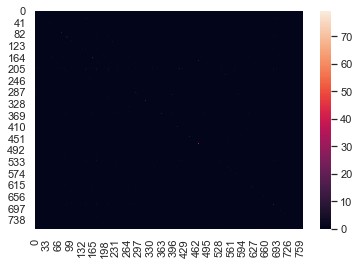

In [45]:
sns.heatmap(adjMatrixNumSimilar)

<AxesSubplot:>

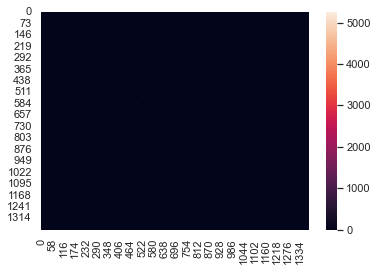

In [44]:
sns.heatmap(coocAdjMatrix)

It's rather apparent from the co-occurence matrix that using the full dictionary of words in the dataset is very sparse.

<AxesSubplot:>

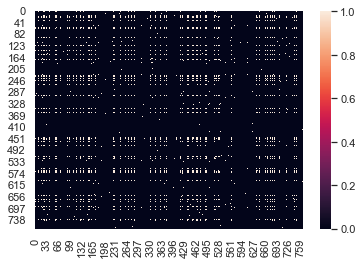

In [61]:
sns.heatmap(cosSimMatrix)

### Topic Extraction Models

##### LDA

In [ ]:
# on the whole data
vectorizer = CountVectorizer()
numTopics = 2 # hyperparameter
lda = LDA(n_components=numTopics) 

doc = []

print("Building Corpus...")
t0 = time()
for hash in df.index:
    hashDoc = df.loc[hash][adjColumnName]
    doc.append(hashDoc)
doc = list(itertools.chain(*doc)) # concatenates nested list into 1D list
X = vectorizer.fit_transform(doc).toarray() # sparse matrix of token counts
print("done in %0.3fs.\n" % (time() - t0))

print("Fitting Corpus...")
t0 = time()
lda.fit(X)
print("done in %0.3fs.\n" % (time() - t0))

cols = vectorizer.get_feature_names_out()
plot_top_words(lda, cols, n_top_words=20, title="Topics in LDA model", n_topics=numTopics)

In [ ]:
# on partitions of data

def filterNode(n1):
    return n1 in nodesInGroup

vectorizer = CountVectorizer()
numTopics = 1 # number of topics to pull out for each community

groupDict = nx.get_node_attributes(G, "group")
groupList = list(Counter(list(nx.get_node_attributes(G, "group").values())))

for community in groupList:

    # get the community's nodes
    nodesInGroup = [n for n in G.nodes if groupDict.get(n, "group")==community]
    subgraph = nx.subgraph_view(G, filter_node=filterNode)
    subgraphHashes = list(nx.get_node_attributes(subgraph, "title").values())

    # build the doc
    doc = []
    
    for hash in subgraphHashes:
        hashDoc = df.loc[hash][adjColumnName]
        doc.append(hashDoc)

    # fit the model
    doc = list(itertools.chain(*doc)) # concatenates nested list into 1D list
    X = vectorizer.fit_transform(doc).toarray() # sparse matrix of token counts

    lda = LDA(n_components=numTopics)
    lda.fit(X)

    # add label to nodes
    cols = vectorizer.get_feature_names_out()
    feats = lda.components_[0]
    featDict = dict(zip(cols, feats))
    labelKeys = sorted(featDict, key=featDict.get, reverse=True)[:3]

    # for n in nodesInGroup:
    #     G.nodes()[n]["title"] += '<br>' + '<br>'.join(labelKeys) # this listing is not working
    #    G.nodes()[n]["value"] = len(labelKeys)

    # plot the topic
    plot_top_words_one_topic(lda, cols, n_top_words=20, title=f"Topics in LDA model for community: {community}")

##### SVD

##### 

### Network Visualization

In [62]:
# input the network you would like to visualize below as a NetworkX object in the first parameter
# recommended to only run this after validating the network with the above graphs and statistics
# if it is taking a while to run/load the image, set _physics=False
visualizeNetworkHTML(Gcossim, _filename="test vector cosine.html", _width="3840px", _height="2160px", _physics=True)

In [ ]:
# bridge node
df.loc["3bad1c0f3b983ab81ddff3f5e90e687310269d16"]

In [ ]:
df.loc["3bad1c0f3b983ab81ddff3f5e90e687310269d16"]["ngram_lc"]